# **Project 3: Hamburger/Hotdog**


## **Import the necessary libraries**

In [15]:
from PIL import Image
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# scikit-learn modules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Library for randomly selecting data points
import random

from Utils import plot_training_history, evaluate_model, plot_confusion_matrix, calculate_additional_metrics

## **Load and Prepare the Dataset**

- Load and standardize the dataset
- Extract and encode lables. 
- Split the data into the train and the test dataset.

In [2]:
# Function to Load Images and Labels
# This function walks through the directory structure, loads the images, converts them into a consistent format,
# resizes them as needed and extracts labels from the directory names:

def load_images_from_folder(folder, count, img_size=(256, 256)):
    images = []
    for idx, filename in enumerate(os.listdir(folder)):
        if idx >= count:  # Only load up to 'count' images
            break
        if filename.endswith('.jpg'):  
            img_path = os.path.join(folder, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert to RGB
                img = img.resize(img_size)  # Resize the image
                images.append(np.array(img))
    return np.array(images)


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [3]:
# Load Images and Create Labels
hotdog_folder = '/Users/jenniferleone/Desktop/AI_Bootcamp/Project 3/Images/HOTDOG'
hamburger_folder = '/Users/jenniferleone/Desktop/AI_Bootcamp/Project 3/Images/HAMBURGER'

# hotdog_folder = "/content/drive/MyDrive/IMAGES/HOTDOG_SOURCE"
# hamburger_folder = "/content/drive/MyDrive/IMAGES/HAMBURGER_SOURCE"

# Load images
hotdog_images = load_images_from_folder(hotdog_folder,1000)
hamburger_images = load_images_from_folder(hamburger_folder,1000)

# Create labels (zeros and ones for the hotdog and notdog images)
hotdog_labels = np.ones(len(hotdog_images))
hamburger_labels = np.zeros(len(hamburger_images))

# Combine images and labels
X = np.concatenate((hotdog_images, hamburger_images), axis=0)
y = np.concatenate((hotdog_labels, hamburger_labels), axis=0)


In [ ]:
print(len(hamburger_images))
print(len(hotdog_images))  

In [4]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

In [ ]:
# Visualize the first 10 images in the dataset and printing their classification labels

def plot_images(images, labels, num_images=10):
    # Set up the figure size in inches
    plt.figure(figsize=(10, 5))
    
    for i in range(num_images):
        # Create a subplot for each image
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')  # Turn off axis numbering
        
    plt.tight_layout()
    plt.show()

plot_images(X_train, y_train)


## **Data preparation**
- Normalize the train and the test dataset by dividing by 255.

In [5]:
# Normalizing the image pixel inputs
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Displaying the first normalized training image
print('Test Dataset:', X_test.shape, y_test.shape)
print('Training Dataset:', X_train.shape, y_train.shape)

In [ ]:
# Displaying the first normalized testing image and its pixel values
print("Shape of the first normalized testing image:", X_test[0].shape)
print("Pixel values of the first normalized testing image:")
print(X_test[0])

## **Model Building**

---
### **CNN Model - Iteration #1**

In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define a CNN model
model_1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
batch_size = 32
epochs = 10
history_1 = model_1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_1, X_test, y_test)


In [ ]:
# Accuracy and Loss Plots
plot_training_history(history_1)

In [ ]:
# Make Predictions
y_pred = model_1.predict(X_test)

# Convert probabilities to binary labels based on a 0.5 threshold
y_pred_labels = (y_pred > 0.5).astype(int)

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(model_1, X_test, y_test,['Hamburger', 'Hotdog'])

### **CNN Model - Iteration #2**

### Augmentation

In [6]:
# Apply augmentation to the whole training dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation (degrees)
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1, # Random vertical shift
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    vertical_flip=False,    # No vertical flip for face images
    fill_mode='nearest'     # Fill mode for handling newly created pixels
)

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]
    
    # Ensure that the input data has the correct shape (Add batch dimension)
    img = np.expand_dims(img, axis=0)

    # Create the iterator
    it = datagen.flow(img, batch_size=1)

    # Add 5 augmented images for every original image
    for j in range(5):
        # Append a new image to the X list
        X_train_aug.append(next(it)[0])  # Correctly use next() with the iterator
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))


8000
8000


In [7]:
# Convert lists to numpy arrays
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

# Ensure X_train_aug is a 4D array and y_train_aug is a 1D array
print("X_train_aug shape:", X_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)


X_train_aug shape: (8000, 256, 256, 3)
y_train_aug shape: (8000,)


In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define CNN model_2
model_2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
batch_size = 32
epochs = 10
history_2 = model_2.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=epochs
)

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_2, X_test, y_test)

In [ ]:
# Accuracy and Loss Plots
plot_training_history(history_2)

In [ ]:
# Confusion Matrix
plot_confusion_matrix(model_2, X_test, y_test,['Hamburger', 'Hotdog'])

### **CNN Model - Iteration #3**

### Dropout
Dropout is a technique where randomly selected neurons are ignored during training, reducing the chance of overfitting. 

In [16]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [17]:
from tensorflow.keras.layers import Dropout

# Define CNN model_3 with Dropout

model_3 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout layer after pooling
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),   # Dropout layer after first dense layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
# Train the model
batch_size = 32
epochs = 10
history_3 = model_3.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 249ms/step - accuracy: 0.5459 - loss: 1.2483 - val_accuracy: 0.6175 - val_loss: 0.6375
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 236ms/step - accuracy: 0.6457 - loss: 0.6229 - val_accuracy: 0.7175 - val_loss: 0.5854
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 217ms/step - accuracy: 0.6895 - loss: 0.5755 - val_accuracy: 0.7100 - val_loss: 0.5417
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.7337 - loss: 0.5010 - val_accuracy: 0.7175 - val_loss: 0.5516
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 227ms/step - accuracy: 0.7757 - loss: 0.4387 - val_accuracy: 0.7000 - val_loss: 0.5998
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 226ms/step - accuracy: 0.8102 - loss: 0.3832 - val_accuracy: 0.7075 - val_loss: 0.6517
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 213ms/step - accuracy: 0.8225 - loss: 0.3434 - val_accuracy: 0.6825 - val_loss: 0.6489
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.8422 - loss: 0

In [19]:
# Evaluating on the Test dataset
evaluate_model(model_3, X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6672 - loss: 0.9945
Test Loss: 0.9950652718544006
Test Accuracy: 0.6575000286102295


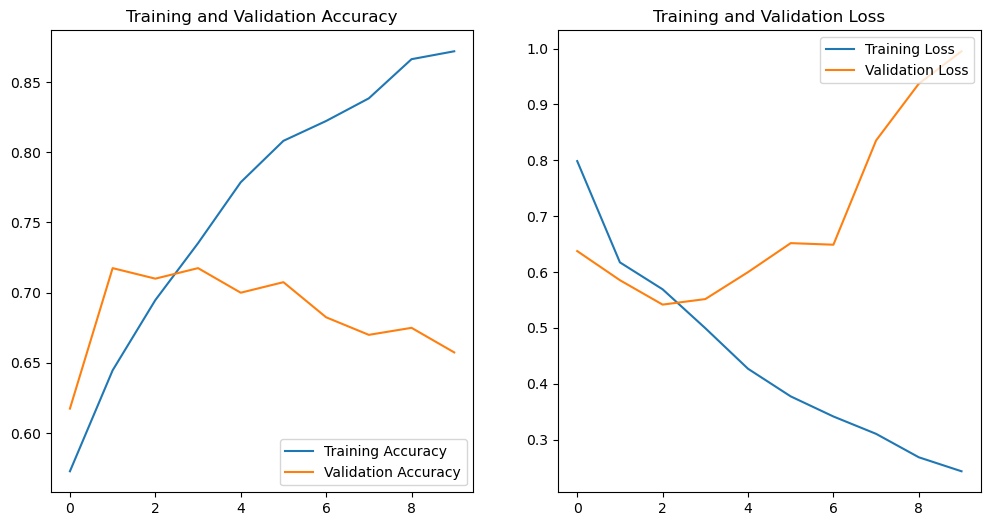

In [20]:
# Accuracy and Loss Plots
plot_training_history(history_3)


In [ ]:
# Confusion Matrix
plot_confusion_matrix(model_3, X_test, y_test,['Hamburger', 'Hotdog'])

### **CNN Model - Iteration #4**

### Early Stopping & Dropout
Early stopping is a method to stop training when the validation metric stops improving, preventing overfitting and saving computational resources.

In [ ]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define a CNN model
model_4 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout layer after pooling
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),   # Dropout layer after first dense layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)

# Fit the model with early stopping
history_4 = model_4.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),  
    epochs=10,  
    callbacks=[early_stopping] 
)

In [ ]:
# Evaluating on the Test dataset
evaluate_model(model_4, X_test, y_test)

In [ ]:
# Accuracy and Loss Plots
plot_training_history(history_4)

In [ ]:
# Confusion Matrix
plot_confusion_matrix(model_4, X_test, y_test,['Hamburger', 'Hotdog'])

### **CNN Model - Iteration #5**

### Additional Layers, Increasing Neurons, Adding Batch Normalization Layers, Early Stopping & Dropout

In [8]:
### Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [9]:
# Define a CNN model
model_5 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


# Compile the model
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Verbosity mode
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)

# Fit the model with early stopping
history_5 = model_5.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),  
    epochs=10,  
    callbacks=[early_stopping] 
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 206s 811ms/step - accuracy: 0.5655 - loss: 6.1772 - val_accuracy: 0.4975 - val_loss: 33.1517
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 197s 784ms/step - accuracy: 0.5966 - loss: 0.7181 - val_accuracy: 0.6100 - val_loss: 3.2660
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 206s 826ms/step - accuracy: 0.6139 - loss: 0.7386 - val_accuracy: 0.6150 - val_loss: 0.6819
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 220s 877ms/step - accuracy: 0.6217 - loss: 0.6497 - val_accuracy: 0.6625 - val_loss: 0.6437
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 890ms/step - accuracy: 0.6478 - loss: 0.6237 - val_accuracy: 0.6525 - val_loss: 0.5987
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 217s 865ms/step - accuracy: 0.6752 - loss: 0.5719 - val_accuracy: 0.6875 - val_loss: 0.7195
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 888ms/step - accuracy: 0.7012 - loss: 0.5351 - val_accuracy: 0.5450 - val_loss: 0.8459
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 220s 880ms/step - accuracy: 0.6359 

In [11]:
# Evaluating on the Test dataset
evaluate_model(model_5, X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6494 - loss: 0.5814
Test Loss: 0.5986537337303162
Test Accuracy: 0.6524999737739563


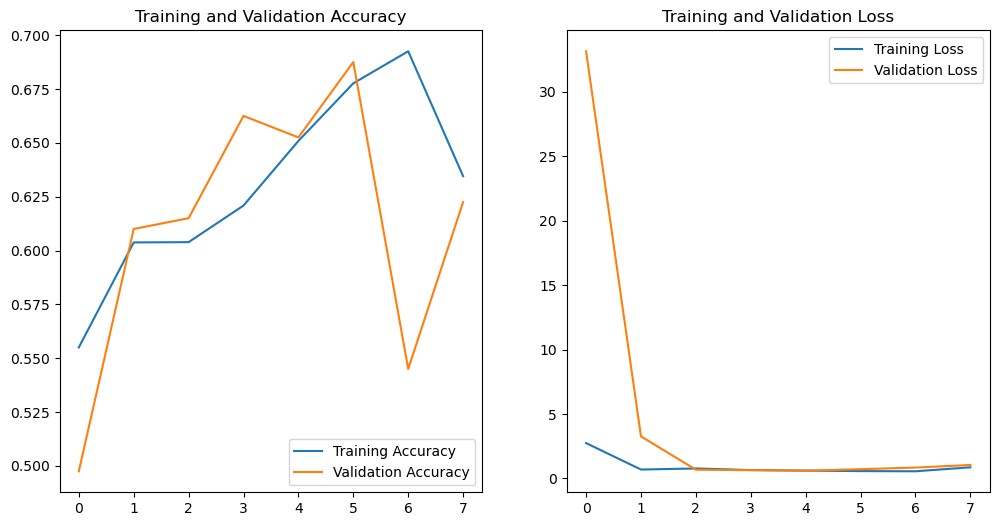

In [13]:
# Accuracy and Loss Plots
plot_training_history(history_5)

In [ ]:
# Confusion Matrix
plot_confusion_matrix(model_5, X_test, y_test,['Hamburger', 'Hotdog'])

In [22]:
from pathlib import Path
# Set the model's file path
file_path = Path("/Users/jenniferleone/Desktop/AI_Bootcamp/Project 3/Fantastic_4_Project_3.keras")

# Export your model
model_3.save(file_path)

In [26]:
import gradio as gr

# Define the prediction function
def predict_image(image):
    # Preprocess the image to fit your model's input requirements
    image = image.resize((256, 256))  # Resize to the input size of the model
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1] if your model expects this range
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict
    prediction = model_3.predict(image)
    prediction = prediction.flatten()[0]  # Get the scalar value from array
    
    # Return the result
    if prediction > 0.5:
        return "Hotdog"
    else:
        return "Hamburger"

# Setup Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(),
    outputs="text",
    examples=["path_to_hamburger_image.jpg", "path_to_hotdog_image.jpg"],  # Adjust paths as needed
    title="Hamburger or Hotdog Classifier",
    description="Upload an image or select one from the examples to see if it's a hamburger or hotdog."
)

# Launch the app
interface.launch(share=True)


/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Running on local URL:  http://127.0.0.1:7861

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
IMPORTANT: You are using gradio version 4.28.3, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://f582800a406a6fd64b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/gradio/route_utils.py", line 270, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/gradio/blocks.py", line 1847, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/gradio/blocks.py", line 1433, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/anyio/to_thread.py", line 28, in run_sync
    return a